# Importing Libraries

In this section, we import the necessary libraries and modules required for the project. These include:
- **Numpy** and **Pandas** for data manipulation and handling.
- **Matplotlib** for plotting and visualizing the data.
- **NLTK** for natural language processing tasks, including stopword removal and stemming.
- **Scikit-learn** for splitting data and evaluating models.
- **TensorFlow/Keras** for building and training deep learning models, specifically an LSTM-based model for sequence prediction.
- **TensorFlow Hub** for pre-trained models that can be used in the neural network.

These libraries will help us preprocess text data, build machine learning models, and evaluate the results.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading Datasets

In this section, we load multiple datasets related to various mental health conditions using **Pandas `read_csv`** function. These datasets contain preprocessed features in TF-IDF format (Term Frequency-Inverse Document Frequency) for different topics, such as:

- **Healthy** (df_healthy)  
- **Addiction** (df_addiction)  
- **Schizophrenia** (df_schizophrenia)  
- **Loneliness** (df_lonely)  
- **Depression** (df_depression)  
- **Autism** (df_autism)  
- **Anxiety** (df_anxiety)  
- **Alcoholism** (df_alcoholism)  
- **ADHD** (df_adhd)  
- **Suicide Watch** (df_suicidewatch)  

Each dataset is read into a DataFrame to be used for model training and analysis. The `read_csv` function is used to load the data from CSV files stored in the working directory.


In [3]:
df_healthy = pd.read_csv("depression_dataset_reddit_cleaned.csv")
df_addiction = pd.read_csv("addiction_pre_features_tfidf_256.csv")
df_schizophrenia = pd.read_csv("schizophrenia_pre_features_tfidf_256.csv")
df_lonely = pd.read_csv("lonely_pre_features_tfidf_256.csv")
df_depression = pd.read_csv("depression_pre_features_tfidf_256.csv")
df_autism = pd.read_csv("autism_pre_features_tfidf_256.csv")
df_anxiety = pd.read_csv("anxiety_pre_features_tfidf_256.csv")
df_alcoholism = pd.read_csv("alcoholism_pre_features_tfidf_256.csv")
df_adhd = pd.read_csv("adhd_pre_features_tfidf_256.csv")
df_suicidewatch = pd.read_csv("suicidewatch_pre_features_tfidf_256.csv")
# df_socialanxiety = pd.read_csv("socialanxiety_pre_features_tfidf_256.csv")

# Preprocessing

In this section, we perform some basic preprocessing steps on the **Healthy** dataset:
1. **Filtering**: We filter out rows where the `is_depression` column is not equal to 0 (i.e., we keep only the rows where `is_depression == 0`, indicating they are healthy posts).
2. **Renaming Columns**: We rename the columns for clarity:
   - The column `is_depression` is renamed to `category` to represent the target variable for classification.
   - The column `clean_text` is renamed to `post` for consistency.
3. **Value Replacement**: The `is_depression` column (which is now `category`) is replaced with the value `"healthy"` for all entries, indicating that these posts belong to the "healthy" category.
4. **Displaying the Data**: We display the first few rows of the cleaned and modified dataset using `head()`.

This data is now ready for further processing and model training.


In [4]:
df_healthy = df_healthy[df_healthy["is_depression"] == 0]
df_healthy.rename(columns = {'is_depression':'category', "clean_text" : "post"}, inplace = True)

df_healthy.replace(0, "healthy", inplace = True)
df_healthy.head()

,post,category
3831,switchfoot http twitpic com y zl awww that s a...,healthy
3832,is upset that he can t update his facebook by ...,healthy
3833,kenichan i dived many time for the ball manage...,healthy
3834,my whole body feel itchy and like it on fire,healthy
3835,nationwideclass no it s not behaving at all i ...,healthy


# Creating and Combining Category DataFrames

In this section, we create a separate DataFrame for each mental health category, then combine them into a single DataFrame:
1. **Creating Category DataFrames**: We define a function `create_category_df` that takes a DataFrame and a category name as inputs. This function returns a new DataFrame with the `category` column set to the specified category name, and the `post` column copied from the original dataset.
   - We create category DataFrames for each of the mental health conditions:
     - **Healthy** (df_healthy_cat)
     - **Addiction** (df_addiction_cat)
     - **Schizophrenia** (df_schizophrenia_cat)
     - **Loneliness** (df_lonely_cat)
     - **Depression** (df_depression_cat)
     - **Autism** (df_autism_cat)
     - **Anxiety** (df_anxiety_cat)
     - **Alcoholism** (df_alcoholism_cat)
     - **ADHD** (df_adhd_cat)
     - **Suicide Watch** (df_suicidewatch_cat)

2. **Concatenating DataFrames**: All the category DataFrames are combined into a single DataFrame using `pd.concat`. This ensures that we have a consolidated dataset with all the posts labeled by their respective categories.

3. **Resetting the Index**: After combining the DataFrames, we reset the index of the new DataFrame to ensure it is sequential and without gaps.

4. **Displaying the Combined Data**: Finally, we print the first few rows of the combined DataFrame to inspect the structure and ensure the concatenation was successful.

The combined DataFrame is now ready for further analysis or modeling.


In [5]:
def create_category_df(df, category_name):
    return pd.DataFrame({'category': category_name, 'post': df['post']})

# Creating category DataFrames
df_healthy_cat = create_category_df(df_healthy, 'healthy')
df_addiction_cat = create_category_df(df_addiction, 'addiction')
df_schizophrenia_cat = create_category_df(df_schizophrenia, 'schizophrenia')
df_lonely_cat = create_category_df(df_lonely, 'lonely')
df_depression_cat = create_category_df(df_depression, 'depression')
df_autism_cat = create_category_df(df_autism, 'autism')
df_anxiety_cat = create_category_df(df_anxiety, 'anxiety')
df_alcoholism_cat = create_category_df(df_alcoholism, 'alcoholism')
df_adhd_cat = create_category_df(df_adhd, 'adhd')
df_suicidewatch_cat = create_category_df(df_suicidewatch, 'suicidewatch')

# Concatenating all category DataFrames into one
df_combined = pd.concat([df_healthy_cat, df_addiction_cat, df_schizophrenia_cat, df_lonely_cat, df_depression_cat, df_autism_cat, df_anxiety_cat, df_alcoholism_cat, df_adhd_cat, df_suicidewatch_cat])

# Resetting index for the combined DataFrame
df_combined.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
print(df_combined.head())

  category                                               post
0  healthy  switchfoot http twitpic com y zl awww that s a...
1  healthy  is upset that he can t update his facebook by ...
2  healthy  kenichan i dived many time for the ball manage...
3  healthy       my whole body feel itchy and like it on fire
4  healthy  nationwideclass no it s not behaving at all i ...


# Checking Class Distribution and Identifying Imbalance

After combining all the datasets, we check the distribution of the categories in the combined dataset using `value_counts()`. The output shows the following distribution of posts across different categories:

- **Depression**: 21,209 posts
- **Anxiety**: 19,976 posts
- **Suicide Watch**: 19,944 posts
- **ADHD**: 16,696 posts
- **Loneliness**: 11,545 posts
- **Autism**: 4,576 posts
- **Schizophrenia**: 4,281 posts
- **Addiction**: 4,099 posts
- **Healthy**: 3,900 posts
- **Alcoholism**: 3,087 posts

### Imbalance Observations:
- There is a clear **class imbalance** in the dataset, where categories like **Depression**, **Anxiety**, and **Suicide Watch** have significantly more samples compared to categories like **Alcoholism**, **Healthy**, and **Addiction**.
- The **Healthy** category, in particular, has the least number of posts, which could impact the model’s performance, as it may not be well-represented during training.
- The imbalance can lead to the model being biased towards the majority classes and may not generalize well to the minority classes.

### Next Steps:
To address the class imbalance, techniques such as **resampling**, **class weights adjustment**, or **synthetic data generation** (e.g., using SMOTE) could be considered.


In [6]:
df_combined.category.value_counts()

category
depression       21209
anxiety          19976
suicidewatch     19944
adhd             16696
lonely           11545
autism            4576
schizophrenia     4281
addiction         4099
healthy           3900
alcoholism        3087
Name: count, dtype: int64

# Text Preprocessing Function

In this section, we define a function `preprocessing` that cleans and prepares text data for further analysis or model training. The function performs the following steps:

1. **Convert to String**: Ensures the input text is converted to a string type.
2. **Remove Retweets**: Strips out any retweet indicator text (e.g., "RT").
3. **Remove HTML Line Breaks**: Removes any HTML line breaks (`<br />`) from the text.
4. **Remove URLs**: Eliminates any URLs from the text (e.g., starting with "http", "https", or "www").
5. **Remove Numbers and Special Characters**: Removes numbers and non-alphanumeric characters (e.g., punctuation).
6. **Remove Single Quotes**: Specifically removes single quotes (`'`).
7. **Tokenization**: The text is split into individual words (tokens).
8. **Stopword Removal**: We remove common English stopwords (e.g., "the", "is", "and") to focus on meaningful words.
9. **Stemming**: Each word is reduced to its base form using the **Porter Stemmer**, which helps in grouping similar words together (e.g., "running" becomes "run").
10. **Return Cleaned Text**: The cleaned words are joined back into a single string and returned.

This function will be applied to each post in the dataset to clean the text before it is used in any analysis or modeling tasks.


In [7]:
def preprocessing(text):
    text = str(text)
    
    # Remove retweet "RT" text
    text = re.sub(r'^RT[\s]+', '', text)
    
    # Remove HTML line breaks
    text = re.sub(r'<br />', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove single quotes
    text = text.replace("\'", "")
    
    # Tokenize text
    tokens = text.split()
    
    # Get stopwords and initialize stemmer
    stopwords_english = stopwords.words("english")
    stemmer = PorterStemmer()
    
    cleaned_words = []

    for x in tokens:
        if x not in stopwords_english:
            stem_word = stemmer.stem(x)
            cleaned_words.append(stem_word)
    
    return ' '.join(cleaned_words)


In [8]:
df_combined["cleaned_post"] = df_combined["post"].apply(preprocessing)

In [9]:
df_combined.head()

,category,post,cleaned_post
0,healthy,switchfoot http twitpic com y zl awww that s a...,switchfoot http twitpic com zl awww bummer sho...
1,healthy,is upset that he can t update his facebook by ...,upset updat facebook text might cri result sch...
2,healthy,kenichan i dived many time for the ball manage...,kenichan dive mani time ball manag save rest g...
3,healthy,my whole body feel itchy and like it on fire,whole bodi feel itchi like fire
4,healthy,nationwideclass no it s not behaving at all i ...,nationwideclass behav mad see


# Splitting the Data into Training and Testing Sets

In this section, we split the combined dataset into training and testing sets:
1. **Defining Features and Target**: 
   - **X**: We select the `cleaned_post` column as the feature variable (the input text data).
   - **y**: We select the `category` column as the target variable (the class labels for each post).
   
2. **Train-Test Split**: 
   - We use **`train_test_split`** from Scikit-learn to split the data into training and testing sets.
   - The test size is set to **0.2**, meaning 20% of the data will be reserved for testing, while the remaining 80% will be used for training.
   - The **random_state** is set to 42 to ensure reproducibility of the split.

This step ensures that the model can be trained on one portion of the data and evaluated on a separate, unseen portion to assess its performance.


In [10]:
X = df_combined["cleaned_post"]
y = df_combined["category"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Tokenization and Padding of Text Data

In this section, we prepare the text data for input into a deep learning model by performing tokenization and padding:

1. **Tokenizer Initialization**: 
   - We initialize the **Tokenizer** from Keras with a limit of **5000 words** (most frequent words) and an **out-of-vocabulary (OOV) token** set to `<OOV>` for words not seen during training.
   
2. **Fitting the Tokenizer**: 
   - We fit the tokenizer on the **training data** (`train_x`) using the `fit_on_texts` method. This creates a vocabulary index, where each unique word is mapped to an integer.

3. **Text to Sequences**: 
   - The tokenizer is then used to convert both the **training data** (`train_x`) and the **testing data** (`test_x`) into sequences of integers, where each word in the text is replaced by its corresponding integer from the tokenizer's vocabulary.

4. **Padding Sequences**:
   - The sequences are padded to a uniform length of **100 tokens** using the `pad_sequences` function. Padding is done at the **end** of the sequences (`padding='post'`), and sequences longer than 100 tokens are **truncated** at the end (`truncating='post'`).

This process ensures that all text data is of consistent length and represented as integers, which is required for input into deep learning models like LSTM.


In [11]:
tokenizer = Tokenizer(num_words = 5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)

train_x_sequences = tokenizer.texts_to_sequences(train_x)
test_x_sequences = tokenizer.texts_to_sequences(test_x)

max_length = 100
train_x_padded = pad_sequences(train_x_sequences, maxlen=max_length, padding='post', truncating='post')
test_x_padded = pad_sequences(test_x_sequences, maxlen=max_length, padding='post', truncating='post')

# Defining and Compiling the LSTM Model

In this section, we define and compile a **Bidirectional LSTM** model for text classification:

1. **Model Architecture**:
   - **Embedding Layer**: The input is passed through an **Embedding layer** that converts the integer-encoded words into dense vectors of size 64. The input dimension is set to **5000** (the size of the vocabulary), and the input length is set to **100** (the length of each padded sequence).
   - **Bidirectional LSTM Layer**: A **Bidirectional LSTM** layer with 64 units is used to process the sequential text data. The bidirectional nature of the LSTM allows the model to capture both forward and backward dependencies in the sequence.
   - **Dropout Layer**: A **Dropout layer** with a rate of 0.4 is applied to prevent overfitting by randomly dropping 40% of the neurons during training.
   - **Dense Layer**: A **Dense layer** with 10 units and a **softmax activation function** is added at the output, which is suitable for multi-class classification. The number of units corresponds to the number of categories in the dataset.

2. **Model Compilation**:
   - The model is compiled using **`sparse_categorical_crossentropy`** as the loss function, which is appropriate for multi-class classification problems where the target labels are integers (not one-hot encoded).
   - The **Adam optimizer** is used for optimization, and **accuracy** is set as the evaluation metric.

3. **Model Summary**:
   - We print the **model summary** to inspect the architecture, the number of parameters, and the output shapes at each layer.

This model is now ready for training on the preprocessed text data to classify the posts into the corresponding categories.


In [94]:
from keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),  # Third LSTM layer
    Dropout(0.4),
    Dense(10, activation='softmax')  # Use softmax for multi-class classification
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           320000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 387338 (1.48 MB)
Trainable params: 387338 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Label Encoding for Multi-Class Classification

In this section, we encode the target labels (categories) into numeric values using **Label Encoding**:

1. **Label Encoder Initialization**: 
   - We initialize a **LabelEncoder** from Scikit-learn, which is used to convert categorical labels into numeric values.

2. **Fitting and Transforming Training Labels**:
   - We use the `fit_transform` method of the encoder on the **training labels** (`train_y`) to encode the categories into integer values. This process maps each unique category (e.g., "depression", "anxiety", etc.) to a unique integer.

3. **Transforming Testing Labels**:
   - The same **LabelEncoder** is applied to the **testing labels** (`test_y`) using the `transform` method, ensuring that the categories in the test set are encoded using the same integer mapping as the training set.

The encoded labels will be used as the target variables for training and evaluating the model, allowing the neural network to predict numerical values, which can later be converted back to their original categorical labels.


In [95]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Training the Model

In this section, we train the **Bidirectional LSTM** model on the preprocessed training data:

1. **Model Training**:
   - The `fit` method is used to train the model on the **training data** (`train_x_padded` and `train_y_encoded`).
   - We specify the number of **epochs** as **10**, meaning the model will pass through the entire training dataset 10 times.
   - The **batch size** is set to **32**, which determines the number of samples that will be processed before updating the model's weights.
   - We also provide **validation data** (`test_x_padded` and `test_y_encoded`) to monitor the model's performance on unseen data during training.

2. **Training Progress**:
   - During training, the model will output the loss and accuracy metrics for both the training and validation sets at the end of each epoch, allowing us to track its progress and performance.

This step trains the model to classify posts into different mental health categories based on the input text.


In [96]:
history = model.fit(train_x_padded, train_y_encoded, epochs=10, batch_size=32, validation_data=(test_x_padded, test_y_encoded))

Epoch 1/10
2733/2733 [==============================] - 113s 40ms/step - loss: 1.0199 - accuracy: 0.6422 - val_loss: 0.7798 - val_accuracy: 0.7317
Epoch 2/10
2733/2733 [==============================] - 103s 38ms/step - loss: 0.7308 - accuracy: 0.7513 - val_loss: 0.7762 - val_accuracy: 0.7306
Epoch 3/10
2733/2733 [==============================] - 107s 39ms/step - loss: 0.6718 - accuracy: 0.7687 - val_loss: 0.7273 - val_accuracy: 0.7463
Epoch 4/10
2733/2733 [==============================] - 110s 40ms/step - loss: 0.6310 - accuracy: 0.7828 - val_loss: 0.7363 - val_accuracy: 0.7448
Epoch 5/10
2733/2733 [==============================] - 103s 38ms/step - loss: 0.5964 - accuracy: 0.7937 - val_loss: 0.7438 - val_accuracy: 0.7425
Epoch 6/10
2733/2733 [==============================] - 107s 39ms/step - loss: 0.5600 - accuracy: 0.8040 - val_loss: 0.7616 - val_accuracy: 0.7406
Epoch 7/10
2733/2733 [==============================] - 109s 40ms/step - loss: 0.5291 - accuracy: 0.8146 - val_loss: 0

In [97]:
y_hat = model.predict(test_x_padded)

684/684 [==============================] - 8s 11ms/step


In [98]:
y_hat = [np.argmax(x) for x in y_hat]

# Evaluating Model Performance with Classification Report

In this section, we evaluate the performance of the trained model on the **test data** using the **classification report**:

1. **Classification Report**:
   - We use the **`classification_report`** from Scikit-learn to generate a detailed report on the model's performance.
   - This report includes key metrics such as:
     - **Precision**: The proportion of true positive predictions among all positive predictions made by the model.
     - **Recall**: The proportion of true positive predictions among all actual positive instances.
     - **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure of the model's performance.
     - **Support**: The number of true instances for each category in the test set.

2. **Input to the Report**:
   - The `classification_report` function is called with the predicted labels (`y_hat`) and the true labels (`test_y_encoded`) as input.
   - The predictions (`y_hat`) are assumed to have already been processed (e.g., by applying `argmax` to convert probabilities into class labels).

This report provides a comprehensive evaluation of the model's classification performance across all categories in the dataset.


In [99]:
from sklearn.metrics import classification_report

print(classification_report(y_hat, test_y_encoded))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       880
           1       0.87      0.85      0.86      3485
           2       0.78      0.80      0.79       606
           3       0.81      0.80      0.81      3948
           4       0.80      0.86      0.83       856
           5       0.54      0.60      0.57      3843
           6       0.92      0.92      0.92       802
           7       0.68      0.67      0.67      2326
           8       0.72      0.74      0.73       851
           9       0.70      0.64      0.67      4266

    accuracy                           0.73     21863
   macro avg       0.76      0.76      0.76     21863
weighted avg       0.73      0.73      0.73     21863



In [48]:
label_encoder.classes_

array(['addiction', 'adhd', 'alcoholism', 'anxiety', 'autism',
       'depression', 'healthy', 'lonely', 'schizophrenia', 'suicidewatch'],
      dtype=object)

In [49]:
label_encoder.inverse_transform([9])

array(['suicidewatch'], dtype=object)

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

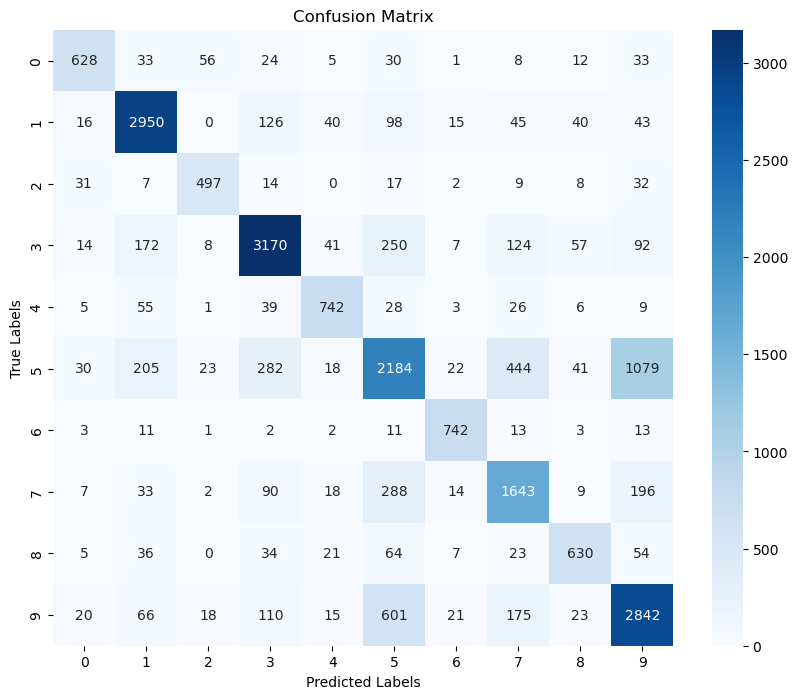

In [51]:
cm = confusion_matrix(test_y_encoded, y_hat, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
test = ["I woke up today with a familiar heaviness in my chest, a weight that has become all too routine. It’s hard to pinpoint exactly when this started, but it feels like it has been forever. I lay in bed for an hour, maybe two, staring at the ceiling, unable to muster the strength to get up. The thought of facing another day feels overwhelming. Everything seems pointless.Eventually, I drag myself out of bed. The room is a mess, clothes strewn everywhere, dishes piled up on the desk. I know I should clean up, but I can’t bring myself to care. I make a half-hearted attempt to tidy up, but it’s too much. I leave it as it is and head to the bathroom. Even brushing my teeth feels like a monumental task.I skip breakfast. I’m not hungry anyway. I sit on the couch and turn on the TV, not really watching. It’s just noise, a distraction from the thoughts in my head. I know I should be doing something productive, but I can’t focus. My mind feels like it’s in a fog, every thought slow and labored.I check my phone. A few messages from friends and family. They mean well, but I don’t have the energy to respond. They ask how I’m doing, if I want to hang out. I don’t know how to explain that I can’t. It’s not that I don’t want to see them, but the idea of social interaction feels exhausting. So, I leave the messages unread, promising myself I’ll reply later, though I know I probably won’t.The day drags on. I try to distract myself with various activities: reading, playing video games, scrolling through social media. Nothing holds my interest for long. I feel restless, yet too tired to do anything. It’s a strange paradox that has become the norm for me.As the afternoon turns into evening, the emptiness inside me grows. I think about my life, about how different it used to be. I had dreams and ambitions once. I wanted to travel the world, have a successful career, maybe start a family. Now, all those dreams seem distant and unattainable. It’s like I’m watching my life from the outside, unable to change its course.Dinner time comes and goes. I eat something, but I can’t taste it. Food is just fuel, something to keep my body going. I sit in silence, lost in my thoughts. The loneliness is suffocating, but I don’t know how to reach out for help. I’ve tried therapy, medication, self-help books. Some days they help, but today is not one of those days.Night falls, and the darkness outside matches how I feel inside. I crawl back into bed, hoping that sleep will come quickly. It’s a temporary escape from the pain, a reprieve from the constant battle in my mind. As I lay there, I think about tomorrow. Will it be any different? Will I find a reason to keep going?Eventually, I drift off to sleep, but even my dreams are restless. They are filled with anxiety and fear, reflections of my waking life. When I wake up tomorrow, I know I’ll face the same struggles. But for now, at least, I have a few hours of peace.This is my reality. Living with depression is like walking through a fog, where every step is uncertain and every day feels the same. But I hold on to the hope that maybe, just maybe, one day the fog will lift. Until then, I take it one day at a time, surviving in the only way I know how."]

In [53]:
test = ["I am not depress for you"]

In [54]:
preprocessing_test = preprocessing(test)

In [55]:
test_sequences = tokenizer.texts_to_sequences(preprocessing_test)

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [56]:
test_padded.shape

(9, 100)

In [57]:
result = model.predict(test_padded)
result

1/1 [==============================] - 0s 48ms/step


array([[1.0881447e-02, 3.4772545e-02, 1.5884049e-02, 1.6567860e-02,
        1.4600017e-02, 1.3735162e-01, 1.4160806e-01, 4.8534039e-02,
        2.6317978e-02, 5.5348235e-01],
       [1.3721023e-03, 1.4184414e-03, 1.1285552e-03, 6.7359704e-04,
        1.4197365e-03, 2.1782201e-03, 9.7987992e-01, 2.4925957e-03,
        1.1424747e-03, 8.2942965e-03],
       [2.7394571e-04, 7.2281261e-04, 2.0872852e-04, 4.0789813e-04,
        2.3104362e-04, 8.6745573e-04, 9.9489450e-01, 4.1047245e-04,
        2.8164100e-04, 1.7015323e-03],
       [1.0006999e-04, 1.5065729e-04, 6.7163062e-05, 4.3571374e-05,
        9.1977163e-05, 1.2463619e-04, 9.9889034e-01, 1.7838027e-04,
        7.6334756e-05, 2.7682801e-04],
       [2.7677450e-05, 6.7093708e-05, 1.6556554e-05, 7.8894645e-06,
        2.2447852e-05, 2.5168421e-05, 9.9971730e-01, 4.8586280e-05,
        1.5890822e-05, 5.1296836e-05],
       [7.9391140e-04, 7.5728644e-04, 7.2433334e-04, 3.2046007e-04,
        7.5974956e-04, 1.5065912e-03, 9.8625803e-01, 1.63

In [58]:
result.shape

(9, 10)

In [59]:
test_x.shape

(21863,)

In [60]:
test_x_padded.shape

(21863, 100)

In [61]:
test_padded.shape

(9, 100)

In [100]:
sample_text = ["I woke up today with a familiar heaviness in my chest, a weight that has become all too routine. It’s hard to pinpoint exactly when this started, but it feels like it has been forever. I lay in bed for an hour, maybe two, staring at the ceiling, unable to muster the strength to get up. The thought of facing another day feels overwhelming. Everything seems pointless.Eventually, I drag myself out of bed. The room is a mess, clothes strewn everywhere, dishes piled up on the desk. I know I should clean up, but I can’t bring myself to care. I make a half-hearted attempt to tidy up, but it’s too much. I leave it as it is and head to the bathroom. Even brushing my teeth feels like a monumental task.I skip breakfast. I’m not hungry anyway. I sit on the couch and turn on the TV, not really watching. It’s just noise, a distraction from the thoughts in my head. I know I should be doing something productive, but I can’t focus. My mind feels like it’s in a fog, every thought slow and labored.I check my phone. A few messages from friends and family. They mean well, but I don’t have the energy to respond. They ask how I’m doing, if I want to hang out. I don’t know how to explain that I can’t. It’s not that I don’t want to see them, but the idea of social interaction feels exhausting. So, I leave the messages unread, promising myself I’ll reply later, though I know I probably won’t.The day drags on. I try to distract myself with various activities: reading, playing video games, scrolling through social media. Nothing holds my interest for long. I feel restless, yet too tired to do anything. It’s a strange paradox that has become the norm for me.As the afternoon turns into evening, the emptiness inside me grows. I think about my life, about how different it used to be. I had dreams and ambitions once. I wanted to travel the world, have a successful career, maybe start a family. Now, all those dreams seem distant and unattainable. It’s like I’m watching my life from the outside, unable to change its course.Dinner time comes and goes. I eat something, but I can’t taste it. Food is just fuel, something to keep my body going. I sit in silence, lost in my thoughts. The loneliness is suffocating, but I don’t know how to reach out for help. I’ve tried therapy, medication, self-help books. Some days they help, but today is not one of those days.Night falls, and the darkness outside matches how I feel inside. I crawl back into bed, hoping that sleep will come quickly. It’s a temporary escape from the pain, a reprieve from the constant battle in my mind. As I lay there, I think about tomorrow. Will it be any different? Will I find a reason to keep going?Eventually, I drift off to sleep, but even my dreams are restless. They are filled with anxiety and fear, reflections of my waking life. When I wake up tomorrow, I know I’ll face the same struggles. But for now, at least, I have a few hours of peace.This is my reality. Living with depression is like walking through a fog, where every step is uncertain and every day feels the same. But I hold on to the hope that maybe, just maybe, one day the fog will lift. Until then, I take it one day at a time, surviving in the only way I know how."]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(sample_padded)

1/1 [==============================] - 0s 21ms/step


In [101]:
label_encoder.inverse_transform([np.argmax(predictions)])

array(['anxiety'], dtype=object)

In [102]:
sample_text = ["The sun rises, but I remain hidden. Every day is a battle with social anxiety. The thought of facing people makes my heart race, my palms sweat. Even simple tasks like grocery shopping feel like climbing a mountain. Crowded places suffocate me; conversations with strangers are terrifying. I rehearse words in my head, fearing judgment. Meetings and social gatherings are nightmares. I yearn for connection but retreat to safety in isolation. Therapy helps, step by step, learning to navigate this invisible enemy. Progress is slow but each small victory matters. One day, I hope to embrace the world without fear."]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(sample_padded)

1/1 [==============================] - 0s 23ms/step


In [103]:
label_encoder.inverse_transform([np.argmax(predictions)])

array(['depression'], dtype=object)

In [104]:
sample_text = ["Each day feels like a whirlwind. The morning starts with good intentions, but distractions quickly take over. I jump from task to task, often leaving projects unfinished. Concentration is a struggle; my mind constantly races with thoughts. Simple routines like getting ready or doing chores feel chaotic. Meetings and deadlines are daunting, as staying focused requires immense effort. I often misplace things and forget appointments. Despite the challenges, there's a silver lining: creativity and spontaneity. I embrace my unique thinking and energy. With support and strategies, I'm learning to harness my strengths and navigate the hurdles life presents."]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')
X
predictions = model.predict(sample_padded)
label_encoder.inverse_transform([np.argmax(predictions)])

1/1 [==============================] - 0s 23ms/step


array(['adhd'], dtype=object)

In [105]:
sample_text = [df_healthy_cat["post"].iloc[1170]]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(sample_padded)
label_encoder.inverse_transform([np.argmax(predictions)])

1/1 [==============================] - 0s 26ms/step


array(['autism'], dtype=object)

In [106]:
sample_text = ["Each day begins with a routine that brings comfort and order. Familiar patterns and predictable activities help me navigate the world. Sensory experiences can be overwhelming; bright lights and loud noises often lead to discomfort. Social interactions can feel complex and confusing, making me prefer solitude or the company of close, understanding friends. I find joy in deep focus on my interests, delving into details that others might overlook. Communication sometimes feels challenging, but I express myself best through my passions and special skills. With understanding and support, I thrive in environments that respect my needs and celebrate my unique perspective."]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')
X
predictions = model.predict(sample_padded)
label_encoder.inverse_transform([np.argmax(predictions)])

1/1 [==============================] - 0s 23ms/step


array(['schizophrenia'], dtype=object)

In [92]:
sample_text = [df_suicidewatch_cat["post"].iloc[1705]]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(sample_padded)
label_encoder.inverse_transform([np.argmax(predictions)])

1/1 [==============================] - 0s 32ms/step


array(['suicidewatch'], dtype=object)

In [93]:
sample_text = ["I have addiction on internet"]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')
X
predictions = model.predict(sample_padded)
label_encoder.inverse_transform([np.argmax(predictions)])

1/1 [==============================] - 0s 36ms/step


array(['suicidewatch'], dtype=object)